In [1]:
import torch
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import glob

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
slides_id_df = pd.read_csv('../get_data/data_sheets/image_id_res.csv')
image_ids = list(slides_id_df.images_id)

In [3]:
import sys
sys.path.append('..')

from utils.slide_utils import match_label

def concate_slide_Embeddings(pt_file_path, file_name):
    pt_files = glob.glob(pt_file_path+'*_slide_tensor.pt')
    embeddings = []
    ids = []

    # Merge embeddings with labels based on image_id
    drug_response = []
    data_source = []
    for pt_file in pt_files:
        id=pt_file.split('_')[0].split(pt_file_path)[1]
        if int(id) in image_ids:
            data = torch.load(pt_file)
            slide_embeds = data['last_layer_embed'][0]
            embeddings.append(slide_embeds.numpy())
            ids.append(id)
            mat_id_df = slides_id_df[slides_id_df['images_id']==int(id)]
            drug_response.append(match_label(list(mat_id_df.ORR)[0]))
            data_source.append(list(mat_id_df.cancer)[0])
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['ids'] = ids
    embeddings_df['drug_response']=drug_response
    embeddings_df['data_source']=data_source
    embeddings_df.to_hdf(file_name, key='df', mode='w')

In [4]:
# Concat all the patch encoding to one H5 file
for i in [5, 10, 20]:
    pt_file_path = f'./{i}XEmbeddings/'
    file_name=f'{i}Xslide_embeding.h5'
    concate_slide_Embeddings(pt_file_path, file_name)

In [5]:
import sys
sys.path.append('..')

from utils.slide_utils import match_label

def concate_X_Embeddings(pt_file_path, file_name):
    pt_files = glob.glob(pt_file_path+'*_tile_tensor.pt')
    embeddings = []
    ids = []
    coord1 = []
    coord2 = []

    # Merge embeddings with labels based on image_id
    drug_response = []
    data_source = []
    for pt_file in pt_files:
        id=pt_file.split('_')[0].split(pt_file_path)[1]
        if int(id) in image_ids:
            data = torch.load(pt_file)
            tile_embeds = data['tile_embeds']
            tile_coords = data['coords']
            for i in range(len(tile_embeds)):
                embeddings.append(tile_embeds[i].numpy())
                coord1.append(tile_coords[i].numpy()[0])
                coord2.append(tile_coords[i].numpy()[1])
                ids.append(id)
                mat_id_df = slides_id_df[slides_id_df['images_id']==int(id)]
                drug_response.append(match_label(list(mat_id_df.ORR)[0]))
                data_source.append(list(mat_id_df.cancer)[0])
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df['ids'] = ids
    embeddings_df['coord1'] = coord1
    embeddings_df['coord2'] = coord2
    embeddings_df['drug_response']=drug_response
    embeddings_df['data_source']=data_source
    embeddings_df.to_hdf(file_name, key='df', mode='w')

In [6]:
# Concat all the patch encoding to one H5 file
for i in [5, 10, 20]:
    pt_file_path = f'./{i}XEmbeddings/'
    file_name=f'{i}Xtile_embeding.h5'
    concate_X_Embeddings(pt_file_path, file_name)

In [7]:
def plot_umap_fig(umap_embeddings, label, ids, title):
    umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
    umap_df['Label'] = label
    umap_df['ID'] = ids

    # Plot the UMAP result
    plt.figure(figsize=(10, 8))
    for label in umap_df['Label'].unique():
        subset = umap_df[umap_df['Label'] == label]
        plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, cmap='Spectral', alpha=0.7, s=0.1)

    plt.title(title)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.show()

In [10]:
embeddings_df20X = pd.read_hdf('20Xtile_embeding.h5')
embeddings_df10X = pd.read_hdf('10Xtile_embeding.h5')
embeddings_df5X = pd.read_hdf('5Xtile_embeding.h5')
embeddings_slides = pd.read_hdf('20Xslide_embeding.h5')

: 

In [11]:
# Perform UMAP clustering
# for df in [embeddings_df20X, embeddings_df10X, embeddings_df5X]:
# df_sample = embeddings_df20X.sample(frac=0.5, random_state=42)
for df in [embeddings_df20X]:
    df=df.dropna()
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, verbose=True)
    umap_embeddings = reducer.fit_transform(df.iloc[:, :1536])


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Aug  7 13:57:54 2024 Construct fuzzy simplicial set
Wed Aug  7 13:57:56 2024 Finding Nearest Neighbors
Wed Aug  7 13:57:57 2024 Building RP forest with 48 trees


In [ ]:
embeddings_df20X
embeddings_df20X['ids'] = embeddings_df20X['ids'].astype(int)
embeddings_df20X['coord1'] = embeddings_df20X['coord1'].astype(int)
embeddings_df20X['coord2'] = embeddings_df20X['coord2'].astype(int)
embeddings_df20X['File_name'] = embeddings_df20X['ids'].astype(str) + '/' + embeddings_df20X['coord1'].astype(str) + 'x_' + embeddings_df20X['coord2'].astype(str) + 'y.jpg'
umap_embed = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
embeddings_df20X['UMAP1'] = umap_embed['UMAP1']
embeddings_df20X['UMAP2'] = umap_embed['UMAP2']

# embeddings_df20X.to_hdf('20xtile_umap_embed.h5', key='df', mode='w')

: 

In [ ]:
def plot_umap_fig(umap_embeddings, label, ids, title):
    umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
    umap_df['Label'] = label
    umap_df['ID'] = ids

    # Plot the UMAP result
    plt.figure(figsize=(10, 8))
    for label in umap_df['Label'].unique():
        subset = umap_df[umap_df['Label'] == label]
        plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, cmap='Spectral', alpha=0.7, s=0.1)

    plt.title(title)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(markerscale=30)

    plt.show() 
plot_umap_fig(umap_embeddings, df.drug_response, df.drug_response, title='20X tile embedding unsupervised Umap')
plot_umap_fig(umap_embeddings, df.data_source, df.drug_response, title='20X tile embedding unsupervised Umap')
plot_umap_fig(umap_embeddings, df.ids, df.drug_response, title='20X tile embedding unsupervised Umap')


: 

In [10]:
df = embeddings_slides
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, verbose=True)
umap_embeddings = reducer.fit_transform(df.iloc[:, :768])
title = 'Slide Level Embedding Unsupervised Umap'


UMAP(n_jobs=1, random_state=42, verbose=True)
Wed Jul 31 21:37:00 2024 Construct fuzzy simplicial set
Wed Jul 31 21:37:00 2024 Finding Nearest Neighbors
Wed Jul 31 21:37:00 2024 Finished Nearest Neighbor Search
Wed Jul 31 21:37:00 2024 Construct embedding


/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Jul 31 21:37:01 2024 Finished embedding


/tmp/ipykernel_1187167/1552973099.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, cmap='Spectral', alpha=0.65, s=35)


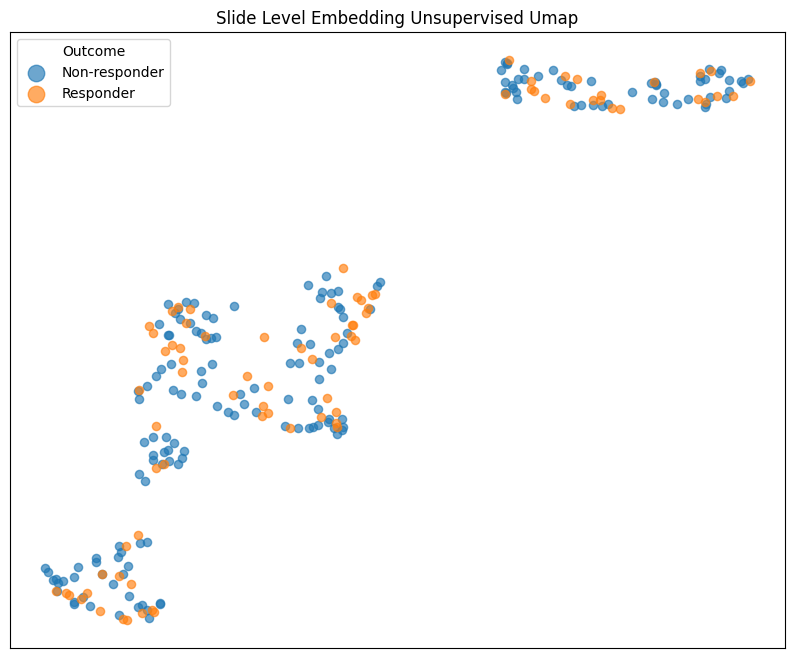

In [20]:
def plot_umap_fig(umap_embeddings, label, title):
    umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'])
    umap_df['Label'] = label

    MATCH_RESPONSE_LABEL = {
        0:'Non-responder',
        1:'Responder'
    }
    umap_df['Label'] = umap_df['Label'].map(MATCH_RESPONSE_LABEL)

    # Plot the UMAP result
    plt.figure(figsize=(10, 8))
    for label in umap_df['Label'].unique():
        subset = umap_df[umap_df['Label'] == label]
        plt.scatter(subset['UMAP1'], subset['UMAP2'], label=label, cmap='Spectral', alpha=0.65, s=35)

    plt.title(title)
    plt.legend(title='Outcome', markerscale=2)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show() 
plot_umap_fig(umap_embeddings, df.drug_response, title)

In [ ]:

crc_df = embeddings_df20X[embeddings_df20X['data_source']=='CRC']
crc_df_embed=crc_df.iloc[:, :1536]

: 

In [ ]:
umap_plot_ids = []
for index, row in crc_df.iterrows():
    if row.drug_response==0:
        umap_plot_ids.append('N-R')
    elif row.drug_response==1:
        umap_plot_ids.append(row.ids)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, verbose=True)
umap_embeddings = reducer.fit_transform(np.array(crc_df_embed))

plot_umap_fig(umap_embeddings, umap_plot_ids, list(crc_df.ids))

: 

In [ ]:
# Perform UMAP clustering
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, verbose=True)
umap_embeddings = reducer.fit_transform(crc_df_embed, crc_df.drug_response)

plot_umap_fig(umap_embeddings, crc_df.drug_response, crc_df.drug_response)

: 